In [ ]:
import os
import random
import shutil
!pip install labelme tensorflow opencv-python matplotlib albumentations

In [96]:
import os
import time
import uuid
import cv2

In [93]:
import re


def remove_files(directory, pattern):
    for root, dirs, files in os.walk(directory):
        for file in filter(lambda x: re.match(pattern, x), files):
            os.remove(os.path.join(root, file))


remove_files('data', '.*\.(jpg|json)')
remove_files('aug_data', '.*\.(jpg|json)')

In [72]:
from braceexpand import braceexpand

# https://www.google.com/search?q=python+make+dirs+like+bash+bracket+expansion -> https://stackoverflow.com/questions/22996645/brace-expansion-in-python-glob
def make_data_dirs_tree(brace_patter_path):
    for file in braceexpand(brace_patter_path):
        os.makedirs(file)

In [71]:
#!mkdir -p data/{,train,test,val}/{images,labels}
dirs_glob_pattern = os.path.join('data', '{,train,test,val}', '{images,labels}')
make_data_dirs_tree(dirs_glob_pattern)

In [ ]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [42]:
!labelme --autosave --output data/labels

[INFO   ] __init__:get_config:70 - Loading config file from: /home/kamui/.labelmerc


In [19]:
import os
import shutil
from datetime import datetime

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

source_dir = 'data'
destination_dir = os.path.join('..', f'v3_data_backup_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}')
copytree(source_dir, destination_dir)
# !cp -r data ../v3_data_backup_$(date +%Y-%m-%d_%H-%M-%S)

In [ ]:
import tensorflow as tf
import json
import numpy as np
import os
from matplotlib import pyplot as plt

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [55]:
import os
images = tf.data.Dataset.list_files(os.path.join('data', 'images', '*.jpg'), shuffle=False)

2023-11-25 10:42:22.287583: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 10:42:22.456857: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data/images/*.jpg'

In [12]:
images.as_numpy_iterator().next()

b'data/images/0132fc4e-896c-11ee-aed7-df8acdbd3581.jpg'

In [56]:
def load_image(path): 
    byte_img = tf.io.read_file(path)
    loaded_image = tf.io.decode_jpeg(byte_img)
    return loaded_image

In [54]:
images = images.map(load_image)

NameError: name 'images' is not defined

In [ ]:
images.as_numpy_iterator().next()

In [16]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [18]:
image_generator = images.batch(4).as_numpy_iterator()

In [23]:
plot_images = image_generator.next()

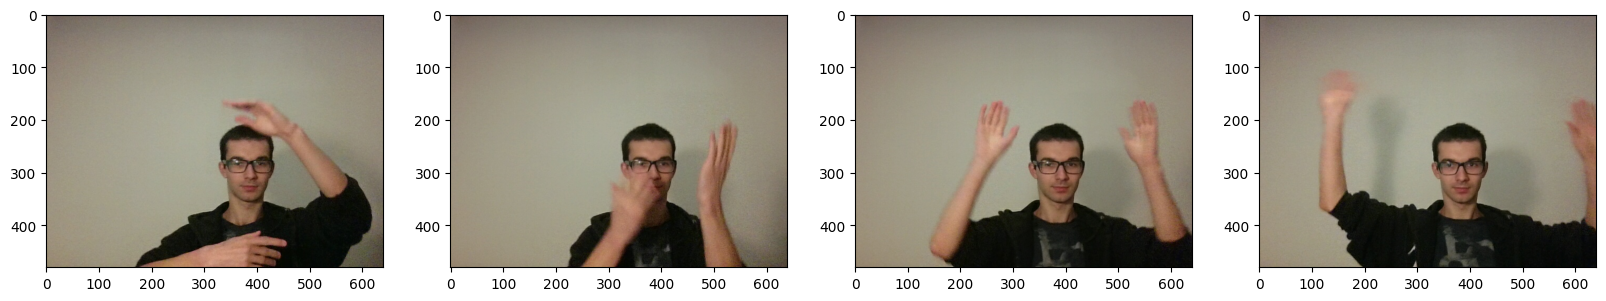

In [24]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# Split Images

In [43]:
## linux move n random files -> https://stackoverflow.com/questions/14033129/how-to-move-a-given-number-of-random-files-on-unix-linux-os
# !shuf -n 63 -e data/images/* | xargs -i mv {} data/train/images
# !shuf -n 14 -e data/images/* | xargs -i mv {} data/test/images
# !shuf -n 13 -e data/images/* | xargs -i mv {} data/val/images
import os
import shutil
import random


def shuffle_and_move(count: int, data_dir: str):
    source_directory = os.path.join('data', 'images')
    destination_directory = os.path.join('data', data_dir, 'images')
    files = os.listdir(source_directory)
    random.shuffle(files)
    files = files[:count]
    for file in files:
        old_path = os.path.join(source_directory, file)
        new_path = os.path.join(destination_directory, file)
        shutil.move(old_path, new_path)

shuffle_and_move(63, 'train')
shuffle_and_move(14, 'test')
shuffle_and_move(13, 'val')

for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

In [45]:
import cv2
import albumentations as alb

augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))

In [57]:
img_name = os.listdir(os.path.join('data', 'train', 'images'))[0]
print(img_name)
img = cv2.imread(os.path.join('data', 'train', 'images', img_name))


03623dd6-896c-11ee-aed7-df8acdbd3581.jpg


In [58]:
with open(os.path.join('data', 'train', 'labels', img_name.replace('.jpg', '.json')), 'r') as f:
    label = json.load(f)

In [61]:
label['shapes'][0]['points']

[[288.2266009852217, 95.9113300492611], [421.7241379310345, 184.0886699507389]]

In [62]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [63]:
coords

[288.2266009852217, 95.9113300492611, 421.7241379310345, 184.0886699507389]

In [64]:
coords = list(np.divide(coords, [640,480,640,480]))

In [65]:
coords

[0.4503540640394089,
 0.1998152709359606,
 0.6589439655172413,
 0.38351806239737274]

In [66]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['hand'])

In [67]:
augmented['bboxes'][0][2:]

(0.8104980842911876, 0.8335303776683087)

In [68]:
augmented['bboxes']

[(0.5138368910782705,
  0.6375807334428024,
  0.8104980842911876,
  0.8335303776683087)]

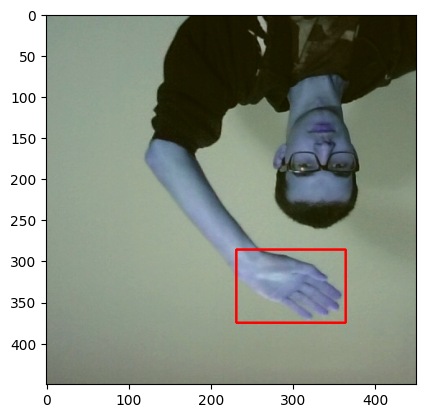

In [70]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
              (255, 0, 0), 2)

plt.imshow(augmented['image'])

In [74]:
# !mkdir -p aug_data/{train,test,val}/{images,labels}
dirs_glob_pattern = os.path.join('aug_data', '{train,test,val}', '{images,labels}')
make_data_dirs_tree(dirs_glob_pattern)

In [75]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['hand'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'),
                            augmented['image'])

                annotation = {'image': image}

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [76]:
def load_images_into_dataset(dir_name: str):
    loaded_images = tf.data.Dataset.list_files(os.path.join('aug_data', dir_name, 'images', '*.jpg'), shuffle=False)
    loaded_images = loaded_images.map(load_image)
    loaded_images = loaded_images.map(lambda y: tf.image.resize(y, (120, 120)))
    loaded_images = loaded_images.map(lambda y: y / 255)
    return loaded_images

In [77]:
train_images = load_images_into_dataset('train')
test_images = load_images_into_dataset('test')
val_images = load_images_into_dataset('val')

In [81]:
train_images.as_numpy_iterator().next()

array([[[0.48780638, 0.436826  , 0.40245098],
        [0.47218138, 0.42058823, 0.39050245],
        [0.4745098 , 0.41568628, 0.39607844],
        ...,
        [0.530576  , 0.5070466 , 0.45998776],
        [0.5360907 , 0.51256126, 0.46550244],
        [0.528799  , 0.51170343, 0.46004903]],

       [[0.501348  , 0.45067403, 0.41446078],
        [0.48327205, 0.43229166, 0.4004902 ],
        [0.48235294, 0.4245098 , 0.4034314 ],
        ...,
        [0.5391544 , 0.515625  , 0.46856618],
        [0.53523284, 0.51170343, 0.4646446 ],
        [0.53860295, 0.51262254, 0.4704657 ]],

       [[0.48817402, 0.4396446 , 0.39699754],
        [0.49724266, 0.44626224, 0.41145834],
        [0.46734068, 0.4163603 , 0.38498774],
        ...,
        [0.5504902 , 0.5269608 , 0.47990197],
        [0.5533701 , 0.5298407 , 0.48278186],
        [0.5541667 , 0.53063726, 0.48357844]],

       ...,

       [[0.6039216 , 0.5568628 , 0.4627451 ],
        [0.6122549 , 0.5651961 , 0.47892156],
        [0.61262256, 0

# Prepare Labels

In [82]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [83]:
def load_labels_into_dataset(dir_name: str):
    loaded_labels = tf.data.Dataset.list_files(os.path.join('aug_data', dir_name, 'labels', '*.json'), shuffle=False)
    loaded_labels = loaded_labels.map(lambda y: tf.py_function(load_labels, [y], [tf.int32, tf.float32]))
    return loaded_labels

train_labels = load_labels_into_dataset('train')
test_labels = load_labels_into_dataset('test')
val_labels = load_labels_into_dataset('val')

In [84]:
train_labels.as_numpy_iterator().next()


(array([1], dtype=int32),
 array([0.6405036 , 0.19313629, 0.9371647 , 0.38908592], dtype=float32))

# Combine Images and Labels

In [85]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

In [86]:
def zip_dataset(images_, labels):
    return tf.data.Dataset.zip((images_, labels)).shuffle(len(labels) + 1).batch(8).prefetch(4)

train = zip_dataset(train_images, train_labels)
test = zip_dataset(test_images, test_labels)
val = zip_dataset(val_images, val_labels)

In [87]:
len(train), len(test), len(val)

(473, 105, 98)

In [89]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1]], dtype=int32),
 array([[0.        , 0.        , 0.        , 0.        ],
        [0.6636453 , 0.15611385, 0.9603065 , 0.6355884 ],
        [0.38944718, 0.35790914, 0.8700164 , 1.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.08789272, 0.58059114, 0.30792555, 0.8695895 ],
        [0.14002189, 0.6439847 , 0.39180076, 1.        ],
        [0.31392446, 0.54240835, 0.56570333, 0.8751943 ],
        [0.12928298, 0.15143952, 0.36683086, 0.46342638]], dtype=float32))

In [90]:
data_samples = train.as_numpy_iterator()

In [97]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


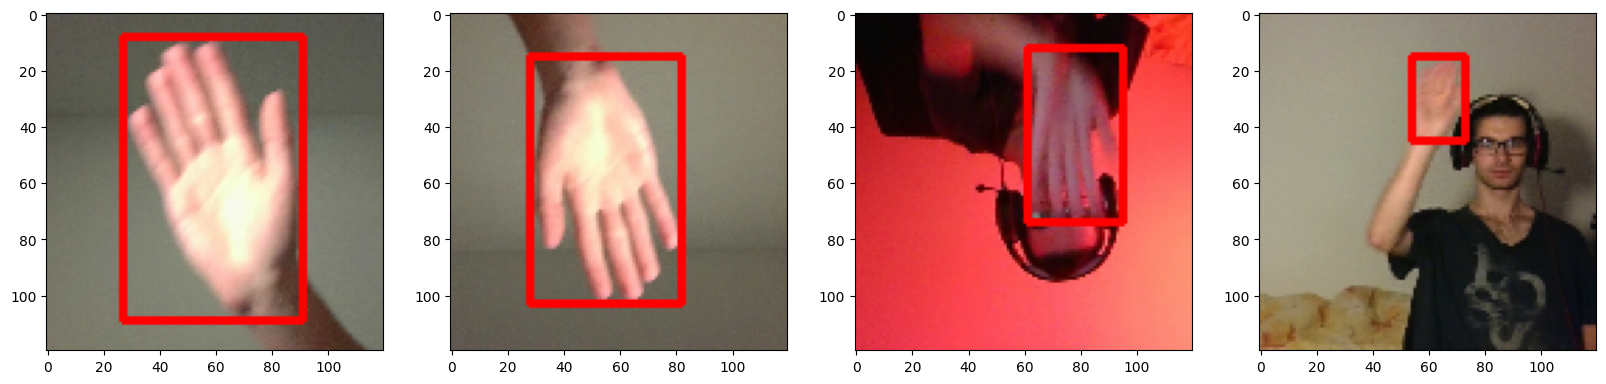

In [98]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                  (255, 0, 0), 2)

    ax[idx].imshow(sample_image)

# Create the Deep Learning Model

In [101]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [102]:
vgg = VGG16(include_top=False)

In [103]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [105]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    tracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return tracker

In [106]:
tracker = build_model()

In [107]:
tracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [108]:
X, y = train.as_numpy_iterator().next()

In [109]:
X.shape

(8, 120, 120, 3)

In [110]:
classes, coords = tracker.predict(X)

1/1 [==============================] - 0s 390ms/step


In [112]:
classes, coords

(array([[0.42780775],
        [0.35735804],
        [0.40900186],
        [0.29917866],
        [0.36499888],
        [0.43713185],
        [0.36448592],
        [0.30550537]], dtype=float32),
 array([[0.4786507 , 0.5891956 , 0.3783927 , 0.6131074 ],
        [0.46348816, 0.6147553 , 0.3373601 , 0.6374175 ],
        [0.46766895, 0.60192525, 0.37804326, 0.5871976 ],
        [0.45588213, 0.5935576 , 0.368359  , 0.6522862 ],
        [0.5226211 , 0.6603674 , 0.35067964, 0.67448485],
        [0.45347765, 0.600222  , 0.36839163, 0.65011847],
        [0.54503167, 0.5906808 , 0.32545933, 0.68641686],
        [0.49769846, 0.5356693 , 0.35055795, 0.6808253 ]], dtype=float32))

# Define Loss Functions

In [113]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [114]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [115]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - yhat[:, :2]))

    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]

    h_pred = yhat[:, 3] - yhat[:, 1]
    w_pred = yhat[:, 2] - yhat[:, 0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size

In [116]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [117]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.861553>

In [118]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0011604>

In [119]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.861553>

In [121]:
class Tracker(Model):
    def __init__(self, tracker, **kwargs):
        super().__init__(**kwargs)
        self.model = tracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5 * batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [125]:
model = Tracker(tracker)

In [126]:
model.compile(opt, classloss, regressloss)

In [127]:
logdir='logs'

In [128]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [56]:
# TODO: 10 or 40 epochs?
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 366s 765ms/step - total_loss: 0.5893 - class_loss: 0.1232 - regress_loss: 0.5277 - val_total_loss: 0.0355 - val_class_loss: 0.0092 - val_regress_loss: 0.0310
Epoch 2/10
473/473 [==============================] - 358s 749ms/step - total_loss: 0.1524 - class_loss: 0.0303 - regress_loss: 0.1372 - val_total_loss: 0.0697 - val_class_loss: 0.0348 - val_regress_loss: 0.0523
Epoch 3/10
473/473 [==============================] - 324s 680ms/step - total_loss: 0.1010 - class_loss: 0.0253 - regress_loss: 0.0883 - val_total_loss: 0.1145 - val_class_loss: 0.0015 - val_regress_loss: 0.1137
Epoch 4/10
473/473 [==============================] - 296s 622ms/step - total_loss: 0.0566 - class_loss: 0.0157 - regress_loss: 0.0488 - val_total_loss: 0.0460 - val_class_loss: 0.0053 - val_regress_loss: 0.0434
Epoch 5/10
473/473 [==============================] - 295s 620ms/step - total_loss: 0.0434 - class_loss: 0.0093 - regress_loss: 0.0387 - val_total_loss:

In [57]:
hist.history

{'total_loss': [0.033223219215869904,
  0.07874571532011032,
  0.012834662571549416,
  0.03844599053263664,
  0.008833648636937141,
  0.006958714686334133,
  0.004040340892970562,
  0.7312063574790955,
  0.0032455450855195522,
  0.0045616887509822845],
 'class_loss': [0.0017653609393164515,
  0.06474356353282928,
  0.000753892760258168,
  0.009841910563409328,
  0.00019337392586749047,
  0.0002793122548609972,
  8.383252861676738e-05,
  0.5937354564666748,
  3.452790042501874e-05,
  7.957307389006019e-06],
 'regress_loss': [0.03234053775668144,
  0.04637393355369568,
  0.012457716278731823,
  0.03352503478527069,
  0.008736961521208286,
  0.006819058675318956,
  0.003998424857854843,
  0.43433862924575806,
  0.003228281158953905,
  0.004557710140943527],
 'val_total_loss': [0.035526957362890244,
  0.06972457468509674,
  0.11446978896856308,
  0.04604032263159752,
  1.89128577709198,
  0.024572793394327164,
  0.04657259210944176,
  0.07253377139568329,
  0.08178139477968216,
  0.0800731

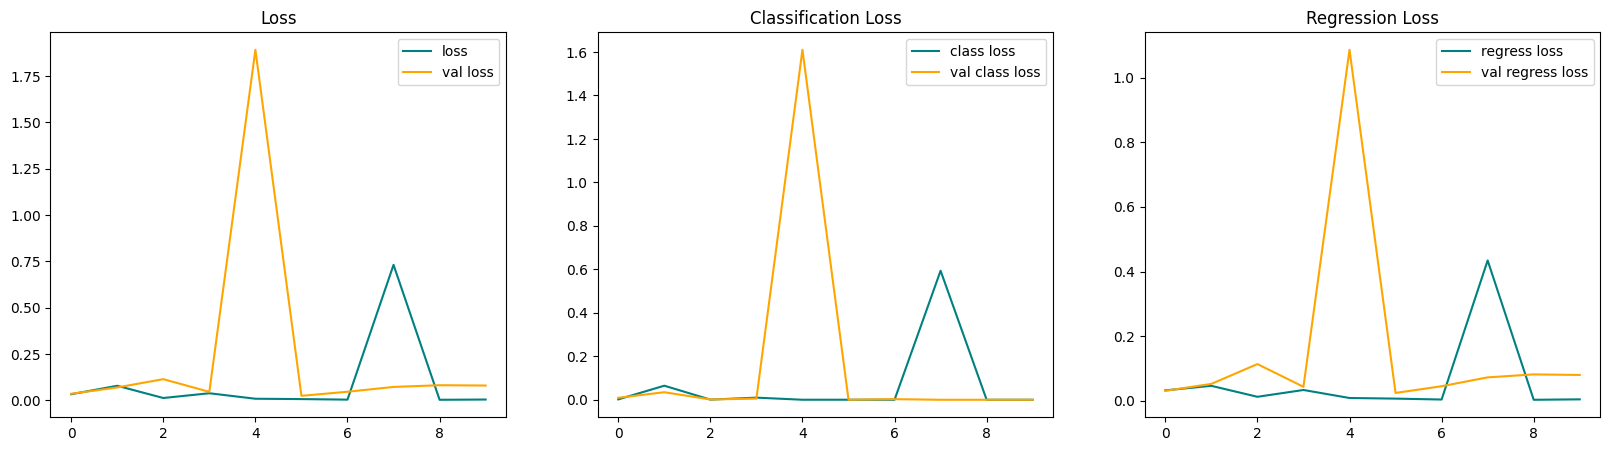

In [58]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# Predictions

In [59]:
test_data = test.as_numpy_iterator()

In [82]:
test_sample = test_data.next()

In [83]:
yhat = tracker.predict(test_sample[0])

1/1 [==============================] - 0s 271ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


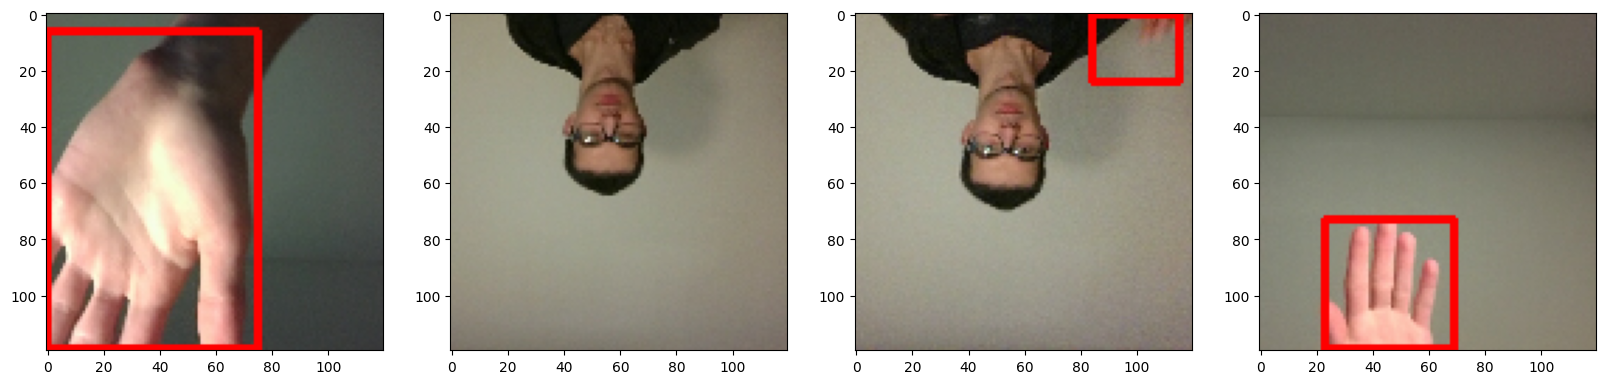

In [84]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                      (255, 0, 0), 2)

    ax[idx].imshow(sample_image)

In [85]:
from tensorflow.keras.models import load_model

In [86]:
tracker.save('tracker.h5')

/mnt/e/UBB_IE_2020-2023/S6.BE/v3/handrecognitionvenv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [88]:
tracker = load_model('tracker.h5')

In [89]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = tracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'hand', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('HandTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 43ms/step


QObject::moveToThread: Current thread (0xe54a940) is not the object's thread (0xe64ede0).
Cannot move to target thread (0xe54a940)

QObject::moveToThread: Current thread (0xe54a940) is not the object's thread (0xe64ede0).
Cannot move to target thread (0xe54a940)

QObject::moveToThread: Current thread (0xe54a940) is not the object's thread (0xe64ede0).
Cannot move to target thread (0xe54a940)

QObject::moveToThread: Current thread (0xe54a940) is not the object's thread (0xe64ede0).
Cannot move to target thread (0xe54a940)

QObject::moveToThread: Current thread (0xe54a940) is not the object's thread (0xe64ede0).
Cannot move to target thread (0xe54a940)

QObject::moveToThread: Current thread (0xe54a940) is not the object's thread (0xe64ede0).
Cannot move to target thread (0xe54a940)

QObject::moveToThread: Current thread (0xe54a940) is not the object's thread (0xe64ede0).
Cannot move to target thread (0xe54a940)

QObject::moveToThread: Current thread (0xe54a940) is not the object's thread

1/1 [==============================] - 0s 52ms/step
